**Задача**

В кредитном скоринге важно оценивать изменчивость p(y|x) во времени, т.е. то, как зависимость целевой переменной (дефолта) изменяется в обучающей выборке со временем.
Почему это важно? Потому что в кредитном скоринге используется т.н. "длинный" таргет, из-за которого обучающая выборка сильно отстает во времени от момента применения скоринговой карты и поэтому, анализируя p(y|x) во времени на обучающей выборке, можно увидеть, что какие-то признаки стали менее информативными с т.зр. предсказания y, в других зависимость p(y|x) заметно изменилась, в каких-то сменилась на противоположную.
Такие признаки опасно использовать в модели, несмотря на то, что они информативны.

Оценивать изменчивость p(y|x) можно:
- визуально
- с помощью мат.статистики (стат. тестов и т.п.)

Требуется предложить методы визуального и статистического анализа p(y|x) и реализовать в виде кода.


**Импорт библиотек**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.model_selection import permutation_test_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.utils import resample

In [2]:
warnings.filterwarnings('ignore')

**Загрузка и предобработка данных**

In [3]:
# Загружаем данные
data = pd.read_csv('application_train.csv')

In [4]:
# Избавляемся от nan добавлением средних значений столбцов или unknown

data_description = data.describe()
for col in data:
    if data[col].dtype == 'object':
        data[col].fillna( 'Unknown', inplace=True)
    else:
        data[col].fillna( data_description[col]['mean'], inplace=True)

In [5]:
# Уменьшаем количество объектов нулевого класса до количества объектов класса 1 (downsampling)

examples_negative = data[data['TARGET'] == 0]

examples_negative_downsampled = resample(
            examples_negative,
            replace=True,
            n_samples=len(data[data['TARGET'] == 1]),
            random_state=0
            )
data_resampled = pd.concat((examples_negative_downsampled, data[data['TARGET'] == 1]), axis=0)

print(data_resampled.shape)

(49650, 122)


In [6]:
# Формируем столбец с целевой переменной
y = data_resampled['TARGET']

# Удаляем столбец с целевой переменной
X = data_resampled.drop(columns=['TARGET'])
X['DAYS_BIRTH'] = X['DAYS_BIRTH'].apply(lambda x: -x/365)
X.rename(columns={'DAYS_BIRTH': 'AGE'}, inplace=True)

In [7]:
col_to_transform = []
# Цикл по столбцам
for col in X:
    # Проверка на соответствие типу 'object'
    if X[col].dtype == 'object':
        # Назначение разных типов трансформеров для данных с разными количествами уникальных значений
        if len(X[col].unique()) <= 3:
            col_to_transform.append( ( [col], LabelEncoder() ) )
        
        else:
            col_to_transform.append( ( [col], OneHotEncoder() ) )
    
    else:
        if len(X[col].unique()) >= 30:
            col_to_transform.append( ( [col], StandardScaler() ) ) 

In [8]:
# Создаем объект DataFrameMapper для трансформации признаков
mapper = DataFrameMapper(col_to_transform, df_out=True)

# Обучаем mapper на данных и трансформируем их
x_processed = mapper.fit_transform(X)

**Обучение модели и предсказание классов для обучающего датасета**

In [9]:
# Проводим кросс-валидацию для модели логистической регрессии,
# находим наилучший коэффициент регуляризации и обучаем лучшую модель
model = GridSearchCV(
    LogisticRegression(random_state=0),
    param_grid={'C': np.arange(0.001, 0.01, 0.001)},
    scoring='roc_auc',
    cv=4,
    verbose=0)

# Обучаем модель на всех имеющихся данных (без тестовой выборки)
model.fit(x_processed, y)

GridSearchCV(cv=4, estimator=LogisticRegression(random_state=0),
             param_grid={'C': array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009])},
             scoring='roc_auc')

In [10]:
# Рассчитываем вероятности каждого класса и сами классы

y_pred = model.predict_proba(x_processed)
y_pred_class = model.predict(x_processed)

**Подготовка данных и построение функции для визуализации и расчета метрики**

In [11]:
# Создаем датафрейм с признаками и значениями целевой переменной (истинные и предсказанные значения)

data_processed = X.copy()
data_processed['TARGET_PROBA'] = y_pred[:,1]
data_processed['TARGET_CLASS'] = y_pred_class
data_processed['TARGET'] = y

# Сортируем датафрейм по столбцу условного времени
data_processed = data_processed.sort_values(by=data_processed.columns[0])

In [12]:
# Функция для расчета автокорреляции списка x со сдвигом lag
def autocorr(x, lag):
    # return np.corrcoef(np.array([x[:round(len(x)/2)], x[round(len(x)/2)+1:len(x)]]))
    return np.correlate(x[:round(len(x)/2)], x[lag:round(len(x)/2) + lag]) 

# Функция для визуализации изменчивости предсказаний модели для указанного признака
def visual(df, col, gaps_number, items_in_range):
    
    # df - данные,
    # col - название колонки с признаком
    # gaps_number - количество разбиений по данному признаку
    # items_in_range - количество объектов во временном интервале

    
    # Далее происходит разделение данных на группы по заданному признаку.
    # Каждый фрагмент данных представляет собой датафрейм, значение признака в котором
    # лежит в определенном диапазоне или равно конкретному значению.
    # Все датафреймы заносятся в список gaps_data.
    
    # Проверка типа данных.
    # Если признак имеет тип 'object', то количество разбиений автоматически подстраивается под
    # число уникальных значений признака независимо от введенного параметра gaps_number.
    if df[col].dtype == 'object':
        # Расчет количества разбиений
        gaps_number = len(df[col].unique())
        # Формирование списка датафреймов, содержащих поддиапазоны указанного признака
        gaps_data = [ df[df[col] == item] for item in df[col].unique() ]
        # Составление списка длин датафреймов из gaps_data
        lenghts = [len(gap) for gap in gaps_data]
        
    else:
        # Расчет интервала разбиения по указанному признаку
        gap_width = (df[col].max() - df[col].min()) / gaps_number
    
        # Цикл по интервалам разбиения.
        # На каждой итерации из исходного датафрейма извлекается определенный поддиапазон
        # и добавляется в список gaps_data.
        gaps_data, lenghts = [], []
        for gap in range(gaps_number+1):
            gaps_data.append(df[
                (df[col] >= df[col].min() + gap * gap_width) &
                (df[col] < df[col].min() + (gap + 1) * gap_width)
                ]
                            )
            # Составление списка длин датафреймов из gaps_data
            lenghts.append(len(gaps_data[gap]))
    
    # Индекс интервала, датафрейм которого имеет максимальную длину
    ind_len_max = lenghts.index(max(lenghts))
    
    # Цикл по интервалам указанного признака
    for gap in range(gaps_number):
        
        score = []
        
        # Цикл по временным интервалам
        for range_ in range(round(len(gaps_data[ind_len_max]) / items_in_range)):
            
            # Извлекаем истинные и предсказанные значения для заданных диапазонов признака и времени
            y_loc = gaps_data[gap]['TARGET'][range_ * items_in_range : (range_ + 1) * items_in_range]
            y_pred_loc = gaps_data[gap]['TARGET_CLASS'][range_ * items_in_range : (range_ + 1) * items_in_range]
            
            # Рассчитываем точность предсказания в заданном диапазоне и добавляем в список
            score.append(accuracy_score(y_loc, y_pred_loc))
            
            '''
            sns.displot(gaps_data[gap][range_ : (range_ + 1) * items_in_range].drop_duplicates(), x=col, hue='TARGET')
            plt.title(f'{col}: {df[col].min() + gap * gap_width}-{df[col].min() + (gap + 1) * gap_width},\
                      range: {range_ * items_in_range}-{(range_ + 1) * items_in_range}')
            '''
        
        # Вывод значения автокорреляции (необходимо доработать функцию visual для правильного расчета в каждом интервале)
        print(f'Автокорреляция для интервала {gap+1}: {autocorr(score, round(len(score)/2))}')
        
        # Строим график зависимости точности предсказания от номера временного интервала (не от времени!)
        if df[col].dtype == 'object':
            label = gaps_data[gap][col].unique()[0]
            
        else:
            label = f'{col}: {round(df[col].min() + gap * gap_width, 2)}-{round(df[col].min() + (gap + 1) * gap_width, 2)}'
        
        plt.plot(
            np.linspace(1, round(len(gaps_data[ind_len_max]) / items_in_range), len(score)),
            score,
            label=label
            )
        plt.xlabel('TIME')
        plt.ylabel('ACCURACY')
        # plt.ylim([0.0, 1.05])
        plt.legend(loc=(1, 0))
    
    # Строим распределение признака для всего датафрейма
    sns.displot(x=col, data=df.drop_duplicates())

**Визуализация некоторых признаков**

Автокорреляция для интервала 1: [nan]
Автокорреляция для интервала 2: [35.296225]
Автокорреляция для интервала 3: [nan]


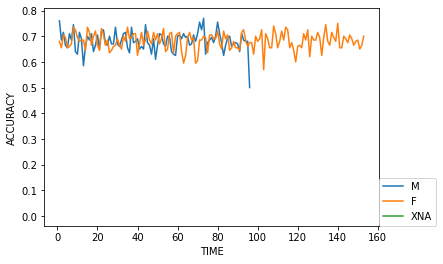

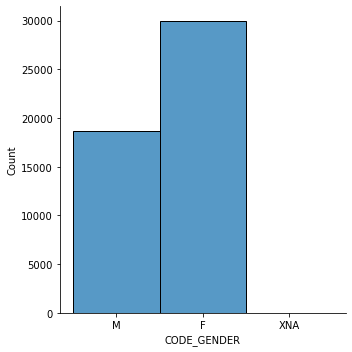

In [13]:
c = visual(data_processed, 'CODE_GENDER', 4, 200)

Автокорреляция для интервала 1: [nan]
Автокорреляция для интервала 2: [7.49462]
Автокорреляция для интервала 3: [nan]
Автокорреляция для интервала 4: [nan]


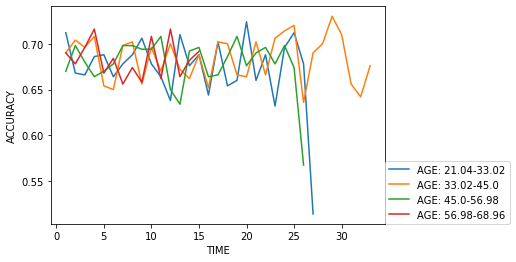

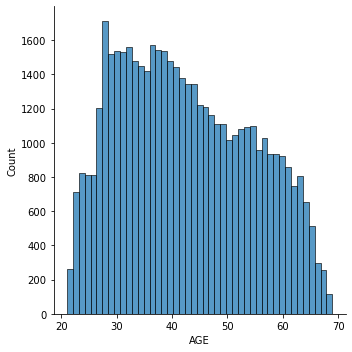

In [14]:
c = visual(data_processed, 'AGE', 4, 500)

Автокорреляция для интервала 1: [nan]
Автокорреляция для интервала 2: [nan]
Автокорреляция для интервала 3: [nan]
Автокорреляция для интервала 4: [nan]
Автокорреляция для интервала 5: [26.88215734]


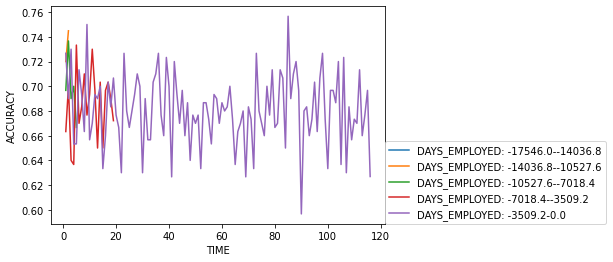

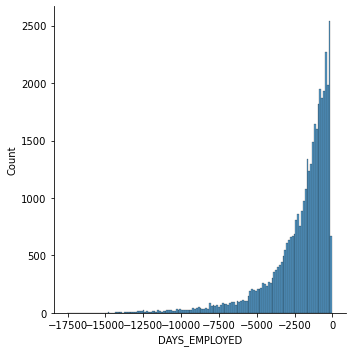

In [15]:
# Отбрасываем строки, в которых количество отработанных дней меньше 15000, чтобы избавиться от выбросов
c = visual(data_processed[data_processed['DAYS_EMPLOYED'] < 15000], 'DAYS_EMPLOYED', 5, 300)

Автокорреляция для интервала 1: [nan]
Автокорреляция для интервала 2: [9.692456]
Автокорреляция для интервала 3: [nan]
Автокорреляция для интервала 4: [nan]
Автокорреляция для интервала 5: [nan]


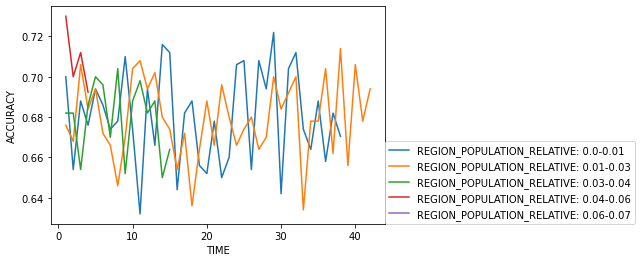

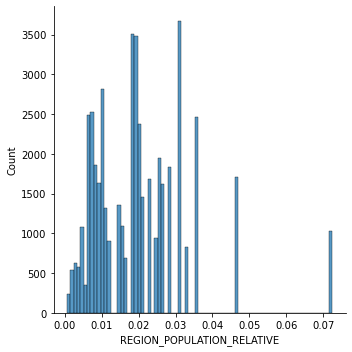

In [16]:
# Отбрасываем строки, в которых количество отработанных дней больше 20000, чтобы избавиться от выбросов
c = visual(data_processed, 'REGION_POPULATION_RELATIVE', 5, 500)

Автокорреляция для интервала 1: [nan]
Автокорреляция для интервала 2: [nan]
Автокорреляция для интервала 3: [nan]
Автокорреляция для интервала 4: [nan]
Автокорреляция для интервала 5: [12.18236]


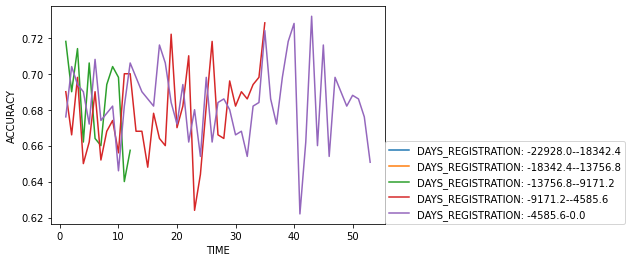

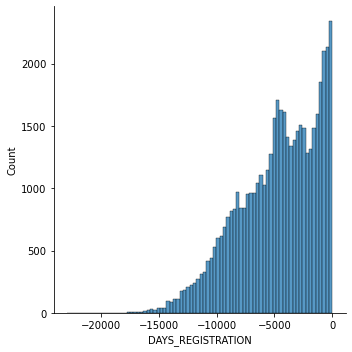

In [17]:
c = visual(data_processed, 'DAYS_REGISTRATION', 5, 500)

Автокорреляция для интервала 1: [nan]
Автокорреляция для интервала 2: [10.15634]
Автокорреляция для интервала 3: [nan]
Автокорреляция для интервала 4: [nan]
Автокорреляция для интервала 5: [nan]


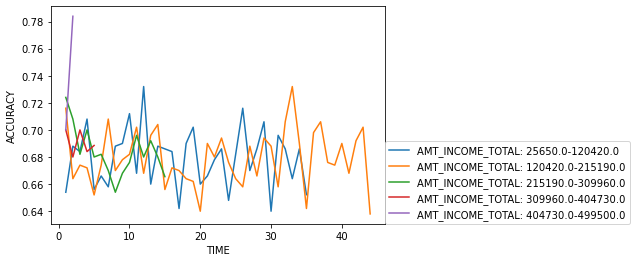

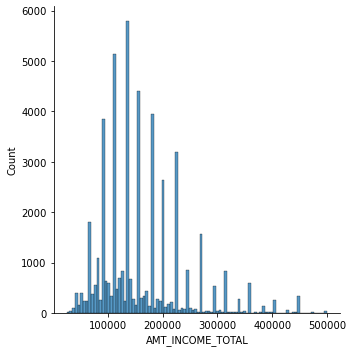

In [18]:
# Отбрасываем строки, в которых зарплата больше 500000, чтобы избавиться от выбросов
c = visual(data_processed[data_processed['AMT_INCOME_TOTAL'] < 500000], 'AMT_INCOME_TOTAL', 5, 500)

Автокорреляция для интервала 1: [nan]
Автокорреляция для интервала 2: [nan]
Автокорреляция для интервала 3: [15.532076]
Автокорреляция для интервала 4: [nan]
Автокорреляция для интервала 5: [nan]


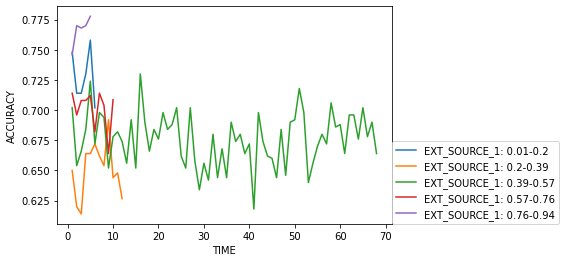

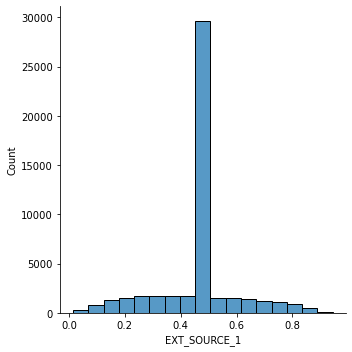

In [19]:
c = visual(data_processed, 'EXT_SOURCE_1', 5, 500)

Автокорреляция для интервала 1: [nan]
Автокорреляция для интервала 2: [nan]
Автокорреляция для интервала 3: [nan]
Автокорреляция для интервала 4: [7.89418171]
Автокорреляция для интервала 5: [nan]


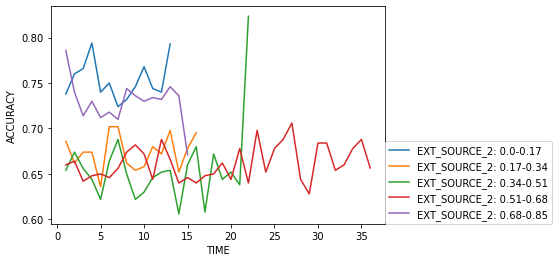

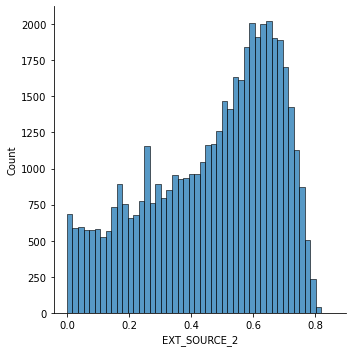

In [20]:
c = visual(data_processed, 'EXT_SOURCE_2', 5, 500)

Автокорреляция для интервала 1: [nan]
Автокорреляция для интервала 2: [nan]
Автокорреляция для интервала 3: [8.81537832]
Автокорреляция для интервала 4: [nan]
Автокорреляция для интервала 5: [nan]


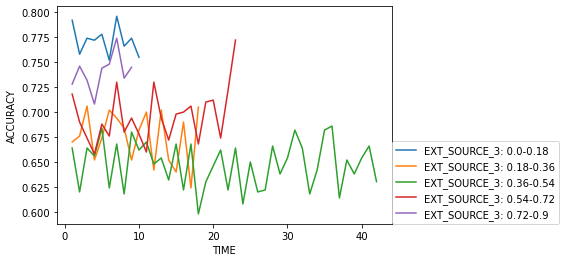

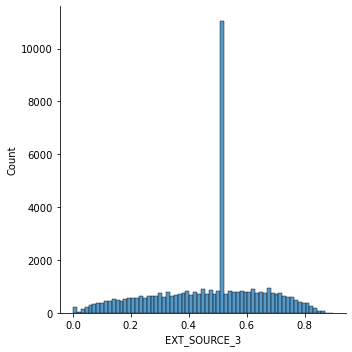

In [21]:
c = visual(data_processed, 'EXT_SOURCE_3', 5, 500)

**Вывод**

На верхнем графике (при вызове функции visual) представлена зависимость точности предсказания от номера временного интервала. По этому графику можно оценить временное изменение качества модели для различных диапазонов выбранного признака. Значение accuracy связано с вероятностью принадлежности объекта к какому-либо классу. Если значение accuracy сильно изменяется с течением времени (наблюдаются скачки на графике), то это может означать, что в более поздние моменты времени появился какой-то фактор, который не учтен в модели. При этом точность модели может резко возрастать, но это не гарантирует, что в скором времени качество предсказания не ухудшится.

Нижний график при вызове функции visual представляет собой распределение признака для всего датасета. Он помогает бороться с выбросами, которые могут исказить данные верхнего графика.

В качестве метрики для оценки изменчивости зависимости точности предсказания от времени может быть использована автокорреляция. Низкое значение автокорреляции будет свидетельствовать об изменении зависимости точности предсказания от времени.

Нерешённые проблемы:
1. Вместо времени используется интервал, из-за чего нарушается масштаб по оси абсцисс (нужен способ усреднить время внутри интервала). Это также приводит к значениям nan автокорреляции для всех интервалов признака, кроме одного.
2. Наличие выбросов (необходима более тщательная предобработка данных)